# Introduction:

Semantic segmentation is a problem of computer vision in which our task is to assign a class to each pixel in the image using that image as an input. In the case of semantic segmentation, we don’t care if we have multiple instances (objects) of the same class, we simply label them all with their class.


There are many reviews on Unet, how it changed the field forever. It is unitively very clear architecture, which consists of an encoder, which generates a representation of the image and a decoder, which uses that representation to build the segmentation. Two maps at each spatial resolution are concatenated (the grey arrows), so you combine two different representations of the image together. 


The next bog thing was using a pre-trained encoder. Think about the image classification problem. Effectively, we try to build a feature representation of the image, such that different classes in that feature space can be separated. We can take (almost) any CNN and use it as an encoder, take features from that encoder and feed them to our decoder.

![](https://miro.medium.com/max/700/1*lvXoKMHoPJMKpKK7keZMEA.png)


* Description

This kernel provides a starter Pytorch-GPU code for inference that performs dividing the images into tiles, selection of tiles with tissue, Train and evaluate of UNet(encode = efficientnet-b3) model, combining the tile masks back into image level masks, conversion into RLE, and visualize the predicted mask for images tests.
The inference is pretrained based on models trained in the kernel.

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-bz8iqx8n
     |████████████████████████████████| 58 kB 862 kB/s eta 0:00:011
     |████████████████████████████████| 244 kB 1.5 MB/s eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=83180 sha256=aee8759818e10b57f94c227257a61a51ce9efbd5adeec99922143db8eafc7007
  Stored in directory: /tmp/pip-ephem-wheel-cache-tohgn7jf/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=d32af297aa441daefd2c4893629184dbccef11c66e53c9ed1bf84a4328390173
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=817195e392976e850f2d4dd86ec5b5a156410ca42edbb53ccb3f2779cbfbb

# Loading Libraries, Parameters, Functions

In [6]:
import uuid
import numba, cv2, gc, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tifffile as tiff 
import seaborn as sns
import rasterio
from rasterio.windows import Window
import pathlib, sys, os, random, time

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T

DATA_PATH = '../input/hubmap-kidney-segmentation'
EPOCHES = 15
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seeds();

In [8]:
df = pd.read_csv("../input/hubmap-kidney-segmentation/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8 non-null      object
 1   encoding  8 non-null      object
dtypes: object(2)
memory usage: 256.0+ bytes


In [5]:
df.head(5)

id                                           encoding
0  2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
1  aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
2  cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
3  0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
4  e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...

In [9]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(256, 256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

def make_grid(shape, window=256, min_overlap=32):
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

 Image shape: (18484, 13013, 3)
 Mask shape: (18484, 13013)
 Resized Image shape: (924, 650, 3)
 Resized Mask shape: (924, 650)


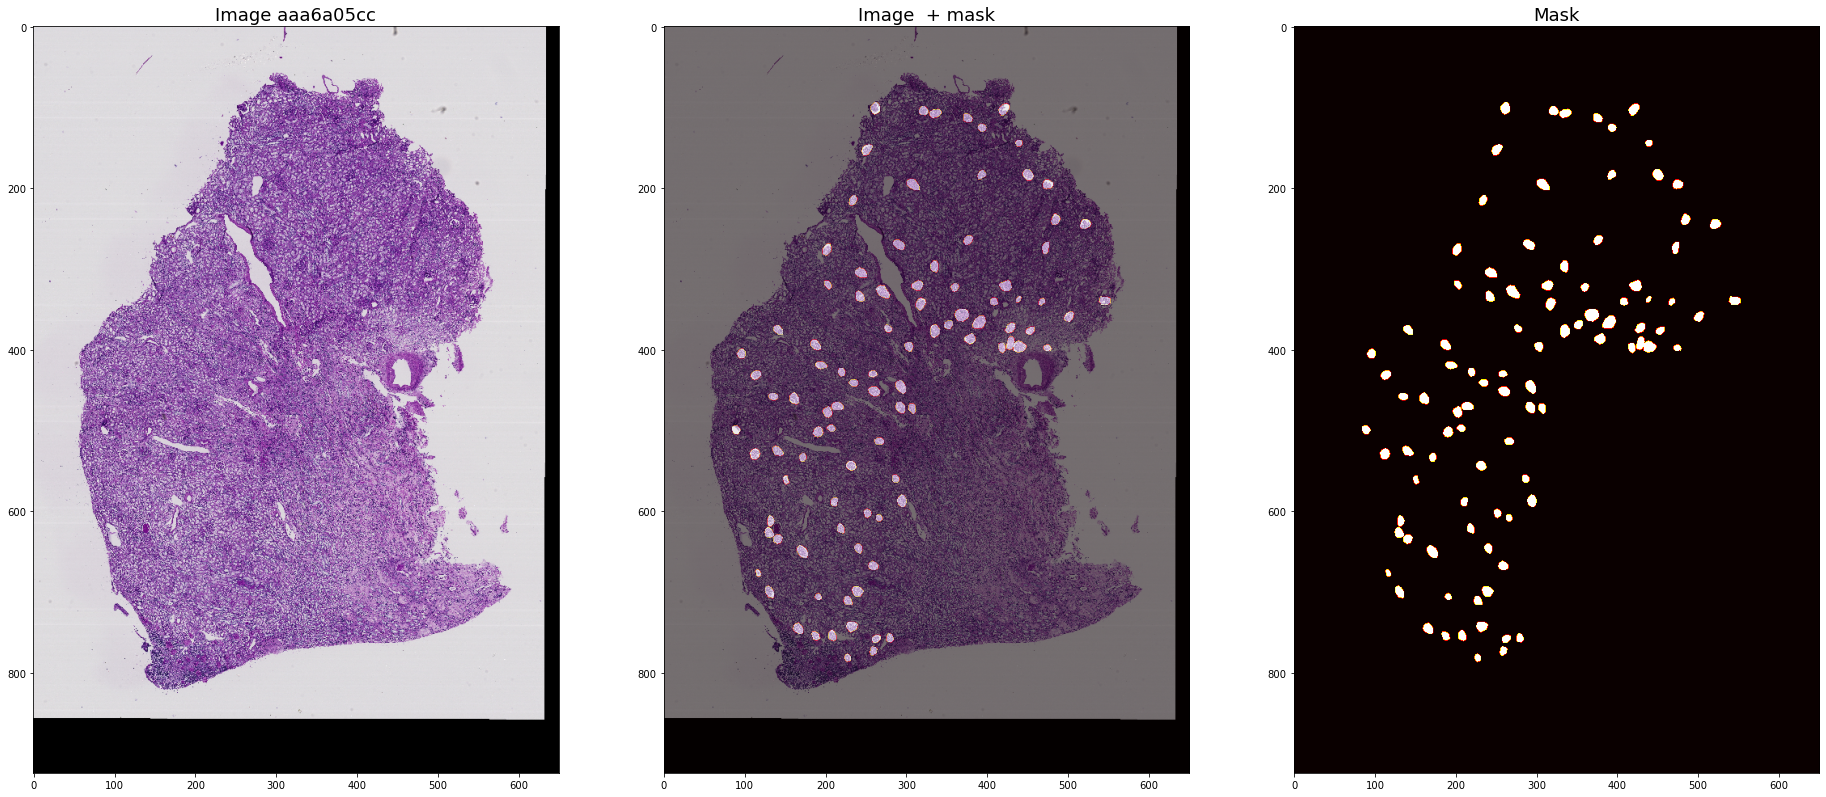

In [7]:
img_id_1 = df.iloc[1,0]
BASE_PATH = '../input/hubmap-kidney-segmentation/train/'
def plot_image(image_id, BASE_PATH = BASE_PATH, scale=None, verbose=1, df = df):
    image = tiff.imread(os.path.join(BASE_PATH, f"{image_id}.tiff"))
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle_decode(df[df["id"] == image_id]["encoding"].values[0], (image.shape[0],image.shape[1]))
    if verbose:
        print(f" Image shape: {image.shape}")
        print(f" Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f" Resized Image shape: {image.shape}")
            print(f" Resized Mask shape: {mask.shape}")
    plt.figure(figsize=(32, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title("Image  + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
            
    del image, mask

plot_image(img_id_1, BASE_PATH ,scale = 20 )

In [8]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

class HubDataset(D.Dataset):

    def __init__(self, root_dir, transform,
                 window=256, overlap=0, threshold = 100):
        self.path = pathlib.Path(root_dir)
        self.overlap = overlap
        self.window = window
        self.transform = transform
        self.csv = pd.read_csv((self.path / 'train.csv').as_posix(),
                               index_col=[0])
        self.threshold = threshold
    
        self.ids = {}
        self.x, self.y = [], []
        self.build_slices()
        self.len = len(self.x)
    
    def build_slices(self):
        self.masks = []
        self.files = []
        self.slices = []
        count = 0
        for i, filename in enumerate(self.csv.index.values):
            tmp = []
            filepath = (self.path /'train'/(filename+'.tiff')).as_posix()
            self.files.append(filepath)
            print(f'Transform-{filename}')
            with rasterio.open(filepath, transform = identity) as dataset:
                self.masks.append(rle_decode(self.csv.loc[filename, 'encoding'], dataset.shape))
                slices = make_grid(dataset.shape, window=self.window, min_overlap=self.overlap)
                
                for slc in tqdm(slices, leave=False):
                    x1,x2,y1,y2 = slc
                    if self.masks[-1][x1:x2,y1:y2].sum() > self.threshold or np.random.randint(100) > 120:
                        self.slices.append([i,x1,x2,y1,y2])
                        
                        image = dataset.read([1,2,3],
                            window=Window.from_slices((x1,x2),(y1,y2)))
                        
                        image = np.moveaxis(image, 0, -1)
                        self.x.append(image)
                        self.y.append(self.masks[-1][x1:x2,y1:y2])
                        tmp.append(count)
                        count += 1
            self.ids[i] = tmp
        with open("folds.pkl", "wb") as f:
            pickle.dump(self.ids, f)
    
    # get data operation
    def __getitem__(self, index):
        img, mask = self.x[index], self.y[index]
        if self.transform is not None:
            augmented = self.transform(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)#self.as_tensor(img), mask
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


In [10]:
import albumentations as A

WINDOW = 256
MIN_OVERLAP = 32
#NEW_SIZE = 512

trfm = A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=1.)

gc.collect()
ds = HubDataset(DATA_PATH, window=WINDOW, overlap=MIN_OVERLAP, transform=trfm)


Transform-2f6ecfcdf


Transform-aaa6a05cc


Transform-cb2d976f4


Transform-0486052bb


Transform-e79de561c


Transform-095bf7a1f


Transform-54f2eec69


Transform-1e2425f28


torch.Size([16, 3, 256, 256])


19

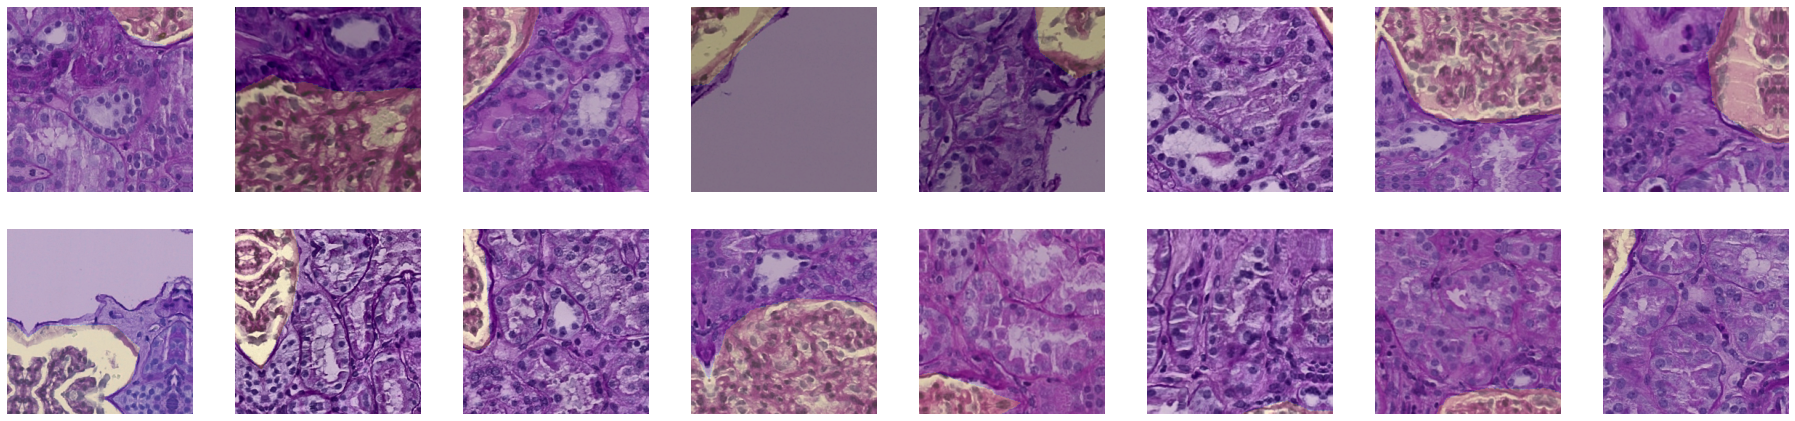

In [11]:
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

d_train = D.DataLoader(ds,batch_size=16,shuffle=False,num_workers=4)
imgs,masks = next(iter(d_train))
print(imgs.shape)
plt.figure(figsize=(32,32))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del imgs,masks
gc.collect()

# Training

## Fonction Loss_DICE

In [12]:
#https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
def dice_coef(output, target):
    smooth = 1e-5
    output_d = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target_d = target.view(-1).data.cpu().numpy()
    intersection = (output_d * target_d).sum()

    return (2. * intersection + smooth) / (output_d.sum() + target_d.sum() + smooth)

## U-Net Model

In [13]:
import segmentation_models_pytorch as smp

model= smp.Unet(encoder_name="efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
                in_channels=3,                  # model input channels (1 for grayscale images, 3 for RGB, etc.)
                classes = 1 )

model.float()
model.to(DEVICE)
model.train()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

## Train Function

In [14]:
torch.cuda.empty_cache()
gc.collect()

34405

In [19]:
from catalyst import dl, contrib
torch.cuda.empty_cache()
num_epochs = 10
base_optimizer = contrib.nn.RAdam([
    {'params': model.decoder.parameters(), 'lr':  5e-3,'weight_decay': 0.00003 }, 
    {'params': model.encoder.parameters(), 'lr':  5e-3/10, 'weight_decay': 0.00003},])

optimizer = contrib.nn.Lookahead(base_optimizer)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5)
diceloss = DiceLoss()
loss_list = [] 
dice_list = []
for epoch in tqdm(range(num_epochs)):
    ###Train
    train_loss = 0
    for data in d_train:
        optimizer.zero_grad()
        img, mask = data
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)

        outputs = model(img)
        dice = dice_coef(outputs, mask)
        loss = diceloss(outputs, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        del mask, img, outputs
        gc.collect()
    train_loss /= =len(d_train)
    print(f"EPOCH: {epoch + 1}/ : {num_epochs}, train_loss: {train_loss}, dice:{dice}")
    loss_list.append(train_loss)
    dice_list.append(dice)
    scheduler.step(train_loss)
del d_train, ds
gc.collect()    
torch.save(model.state_dict(), 'model.pth')

EPOCH: 1/ : 10, train_loss: 0.3320056200027466, dice:0.7587206201155373
EPOCH: 2/ : 10, train_loss: 0.32848942279815674, dice:0.8110950121848175
EPOCH: 3/ : 10, train_loss: 0.311604368686676, dice:0.8034534680092296
EPOCH: 4/ : 10, train_loss: 0.2857722520828247, dice:0.8075307941973163
EPOCH: 5/ : 10, train_loss: 0.28552045822143557, dice:0.8096183151688334
EPOCH: 6/ : 10, train_loss: 0.2749610662460327, dice:0.8430017767153096
EPOCH: 7/ : 10, train_loss: 0.2549409747123718, dice:0.8357979854715946
EPOCH: 8/ : 10, train_loss: 0.2541874170303345, dice:0.8566919894555853
EPOCH: 9/ : 10, train_loss: 0.2605307579040527, dice:0.834646210584364
EPOCH: 10/ : 10, train_loss: 0.24387335777282715, dice:0.8590454977524559



## Results

Text(0.5, 1.0, 'Train diece ')

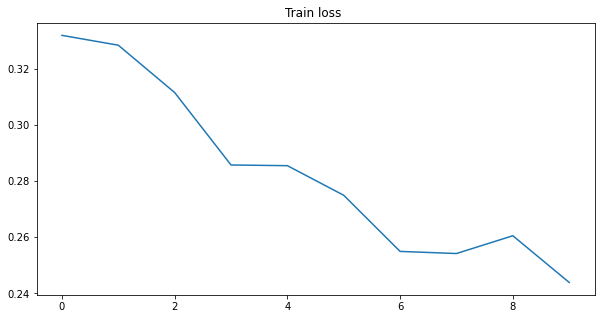

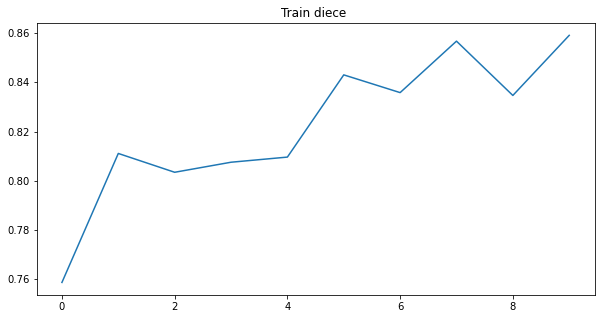

In [24]:
plt.figure(figsize=(10,5))
n_e = np.arange(len(loss_list))
plt.plot(n_e, loss_list)
plt.title('Train loss ')
#plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')

plt.figure(figsize=(10,5))
n_e = np.arange(len(dice_list))
plt.plot(n_e, dice_list)
plt.title('Train diece ')
#plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')

## Results for test images public

In [25]:
WINDOW = 2024
MIN_OVERLAP = 32
NEW_SIZE = 512

trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(NEW_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]), ])

p = pathlib.Path(DATA_PATH)
subm = {}
model.eval()

for i, filename in enumerate(p.glob('test/*.tiff')):
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3], window = Window.from_slices((x1,x2),(y1,y2)))
        image = np.moveaxis(image, 0, -1)
        image = trfm(image)
        with torch.no_grad():
            image = image.to(DEVICE)[None]
            score = model(image)[0][0]
            score_sigmoid = score.sigmoid().cpu().numpy()
            score_sigmoid = cv2.resize(score_sigmoid, (WINDOW, WINDOW))
            
            preds[x1:x2,y1:y2] = (score_sigmoid > 0.5).astype(np.uint8)
            
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect();

In [31]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)


In [11]:
submission

id                                          predicted
0  b9a3865fc  61115390 38 61146684 40 61177978 43 61209269 5...
1  b2dc8411c  56380375 45 56395214 52 56410056 55 56424898 5...
2  26dc41664  220175285 22 220213443 26 220251601 29 2202897...
3  c68fe75ea  21283649 3 21310480 19 21337310 37 21364146 45...
4  afa5e8098  64881238 12 64918037 15 64954836 17 64991633 2...

[b9a3865fc] Image shape: (31295, 40429, 3)
[b9a3865fc] Mask shape: (31295, 40429)
[b9a3865fc] Resized Image shape: (1564, 2021, 3)
[b9a3865fc] Resized Mask shape: (1564, 2021)


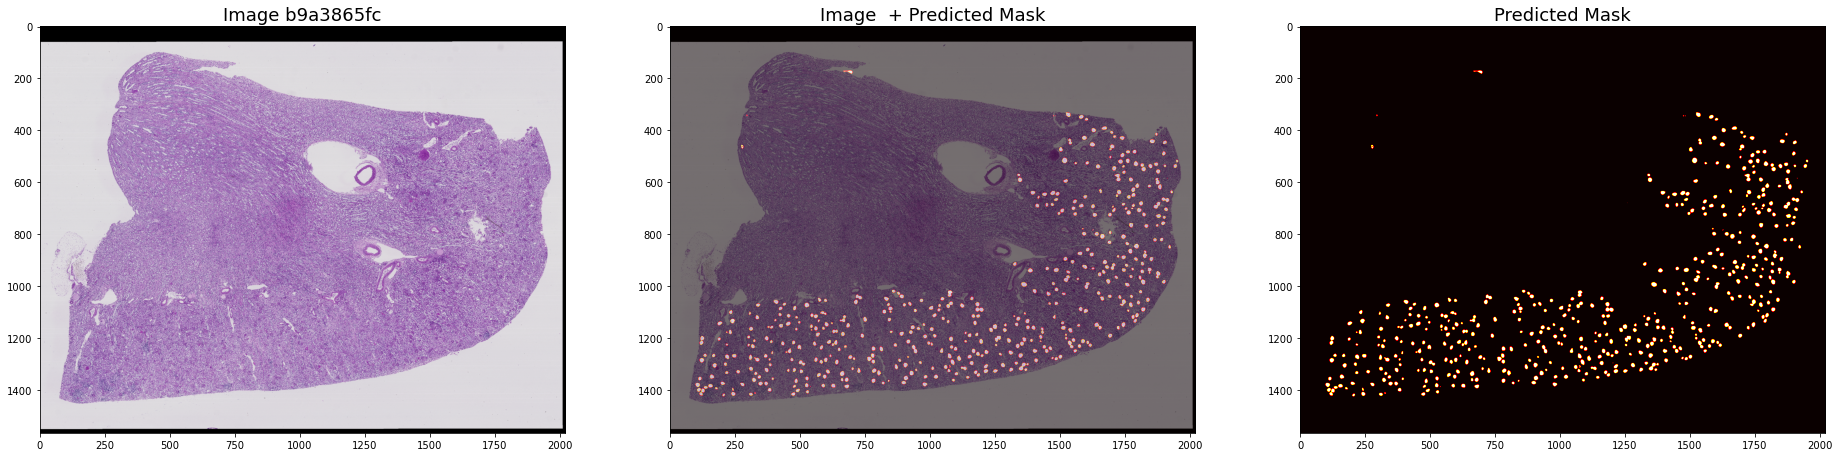

[b2dc8411c] Image shape: (14844, 31262, 3)
[b2dc8411c] Mask shape: (14844, 31262)
[b2dc8411c] Resized Image shape: (742, 1563, 3)
[b2dc8411c] Resized Mask shape: (742, 1563)


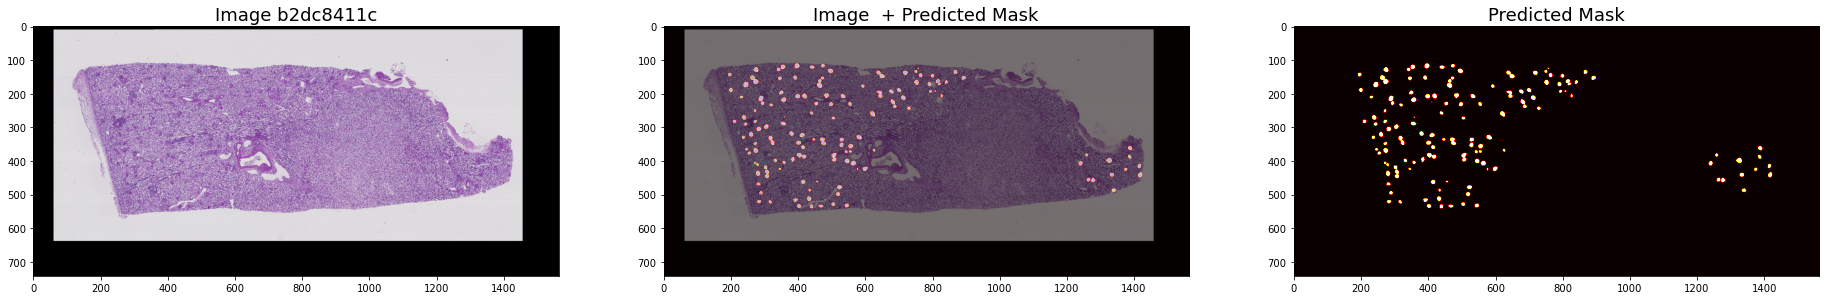

[26dc41664] Image shape: (38160, 42360, 3)
[26dc41664] Mask shape: (38160, 42360)
[26dc41664] Resized Image shape: (1908, 2118, 3)
[26dc41664] Resized Mask shape: (1908, 2118)


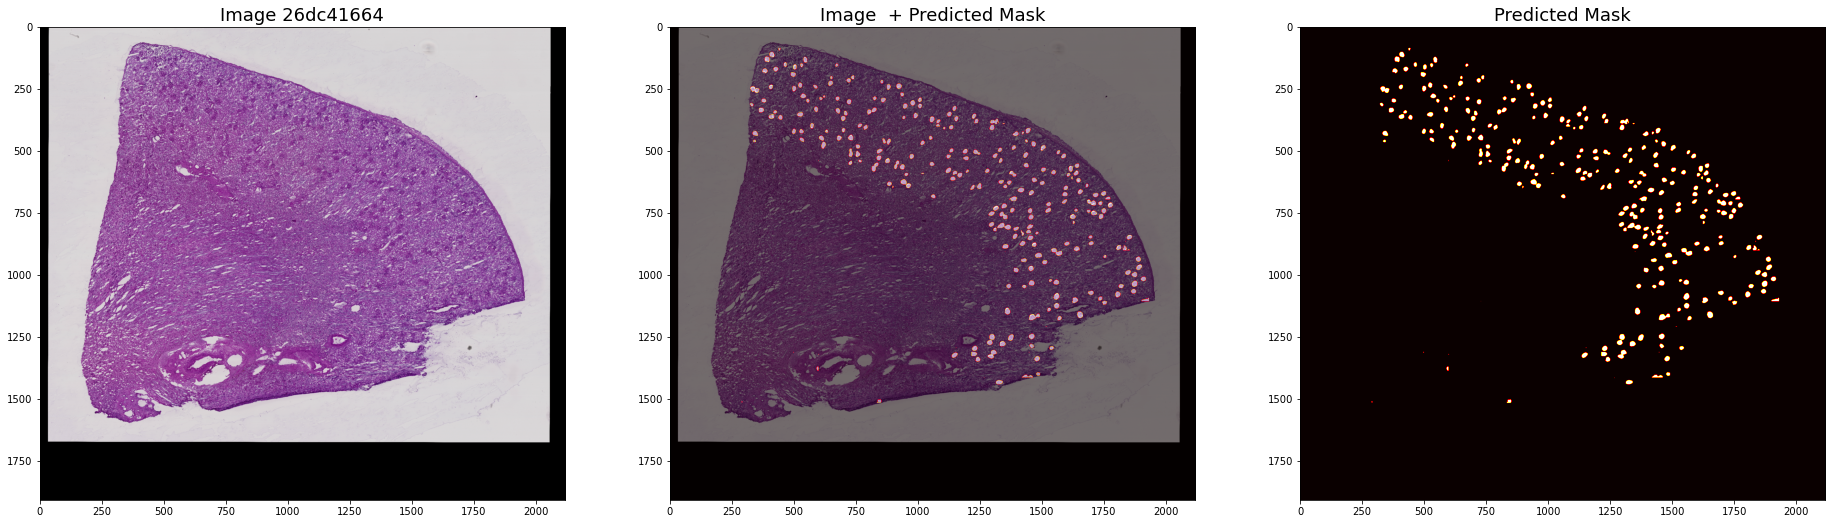

[c68fe75ea] Image shape: (26840, 49780, 3)
[c68fe75ea] Mask shape: (26840, 49780)
[c68fe75ea] Resized Image shape: (1342, 2489, 3)
[c68fe75ea] Resized Mask shape: (1342, 2489)


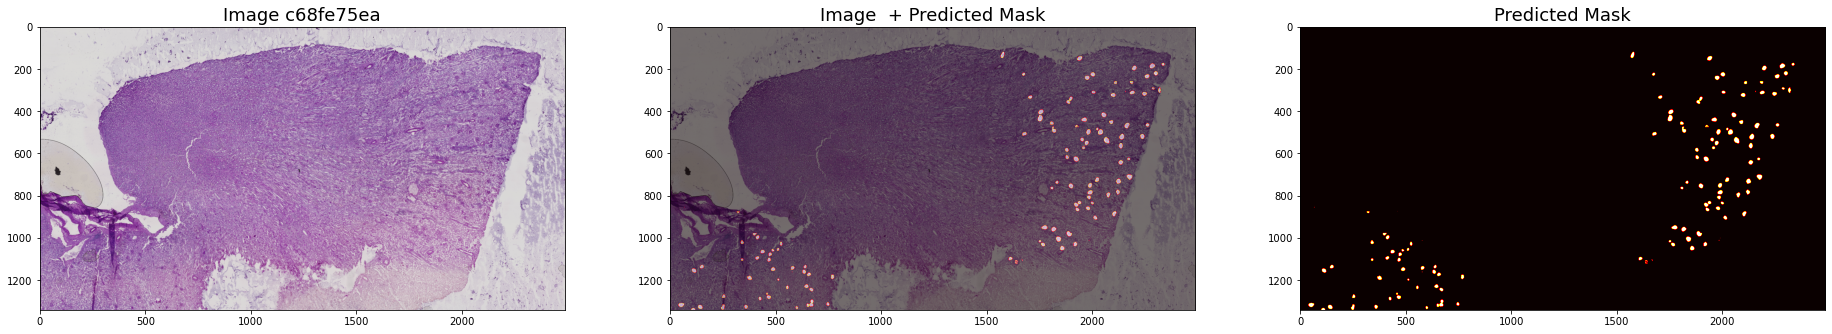

[afa5e8098] Image shape: (36800, 43780, 3)
[afa5e8098] Mask shape: (36800, 43780)
[afa5e8098] Resized Image shape: (1840, 2189, 3)
[afa5e8098] Resized Mask shape: (1840, 2189)


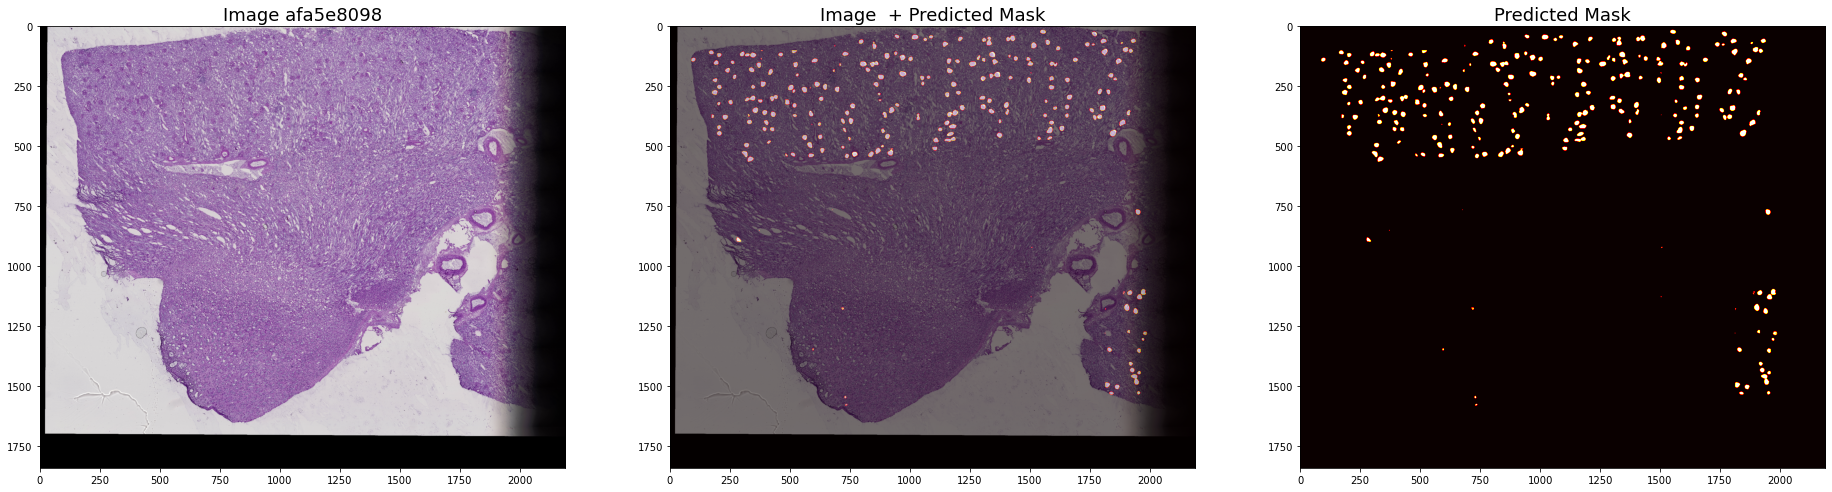

In [12]:
BASE_PATH = '../input/hubmap-kidney-segmentation/test'
def plot_image(image_id, BASE_PATH = BASE_PATH, scale=None, verbose=1, df = submission):
    image = tiff.imread(os.path.join(BASE_PATH, f"{image_id}.tiff"))
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle_decode(df[df["id"] == image_id]["predicted"].values[0], (image.shape[0],image.shape[1]))
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
    plt.figure(figsize=(32, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title("Image  + Predicted Mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Predicted Mask", fontsize=18)    
    
    plt.show()
            
    del image, mask

for i in range(submission.shape[0]):    
    img_id_1 = submission.iloc[i,0]
    plot_image(img_id_1, scale = 20, verbose=1)